<a href="https://colab.research.google.com/github/DariaKIL/Glioblastoma_mutations/blob/main/Plots_MRD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
chim_df = pd.read_csv('/content/drive/MyDrive/МОБ/Химеризмы.csv')
chim_df['Номер ТКМ'] = chim_df['Номер ТКМ'].astype(str)

replacement_dict = {
    'неродст D': 'неродственный донор',
    'сестра': 'сиблинг',
    'брат': 'сиблинг',
    'мама': 'родитель',
    'отец': 'родитель',
    'сын': 'ребенок',
    'дочь': 'ребенок'
}

chim_df['Донор'] = chim_df['Донор'].replace(replacement_dict)

chim_df.head()

,Реципиент,Пол,Возраст,Диагноз,Донор,Дата,Тип,Номер ТКМ,<15 дней,<30 (16-45),<60 (45-75),<90 (76-105),<125 (106-150),<175 (150-200),<225 (201-250),<300,<365,<2 лет,>2 лет
0,Антонов Антон Сергеевич,m,24.0,AML,сиблинг,22.01.19,Гематология,1.0,NaN,NaN,0.0,NaN,83.0,94.0,NaN,NaN,NaN,NaN,NaN
1,Агапочкин Денис Сергеевич,m,32.0,CML,родитель,22.01.19,Гематология,1.0,NaN,0.0,NaN,9.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Агапочкин Денис Сергеевич,m,32.0,CML,родитель,11.07.19,Гематология,2.0,NaN,NaN,7.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN
3,Алфёров Арсений Дмитриевич,m,33.0,AML,родитель,18.08.20,Гематология,1.0,NaN,4.0,0.0,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Алиева Патимат Шапиевна,f,33.0,AML,сиблинг,02.10.19,Гематология,1.0,NaN,NaN,NaN,NaN,7.0,NaN,7.0,NaN,0.0,0.0,0.0


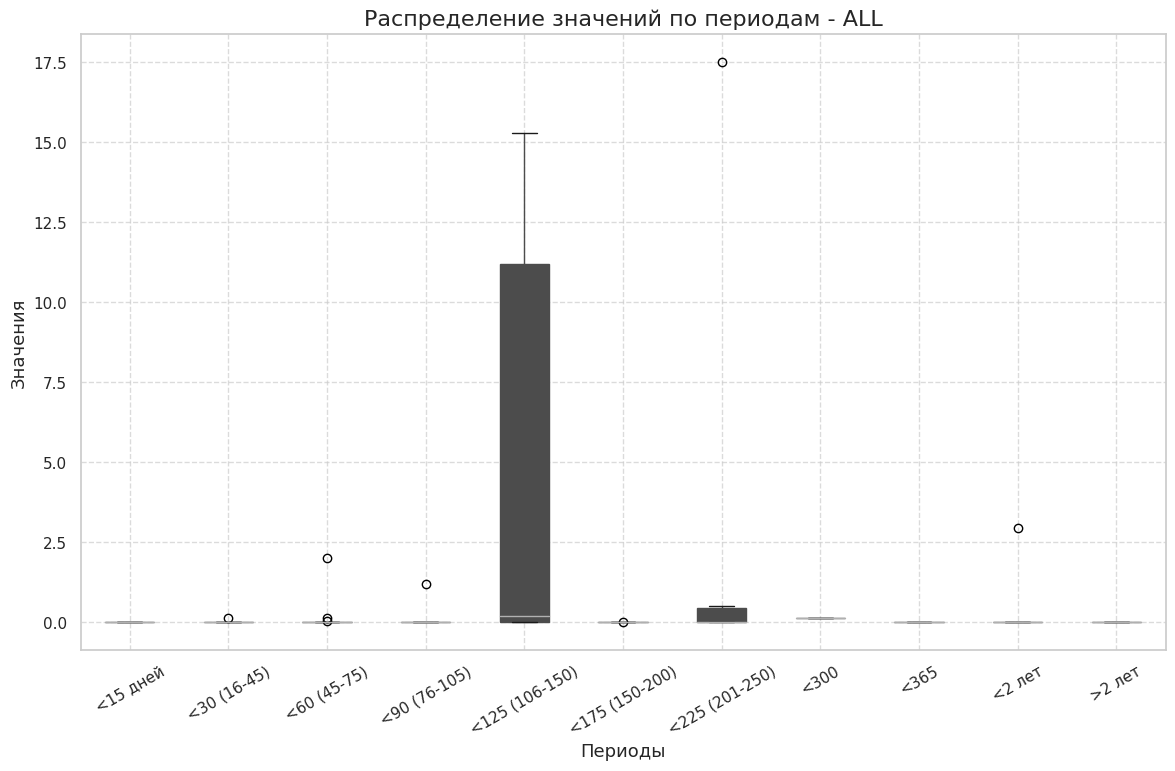

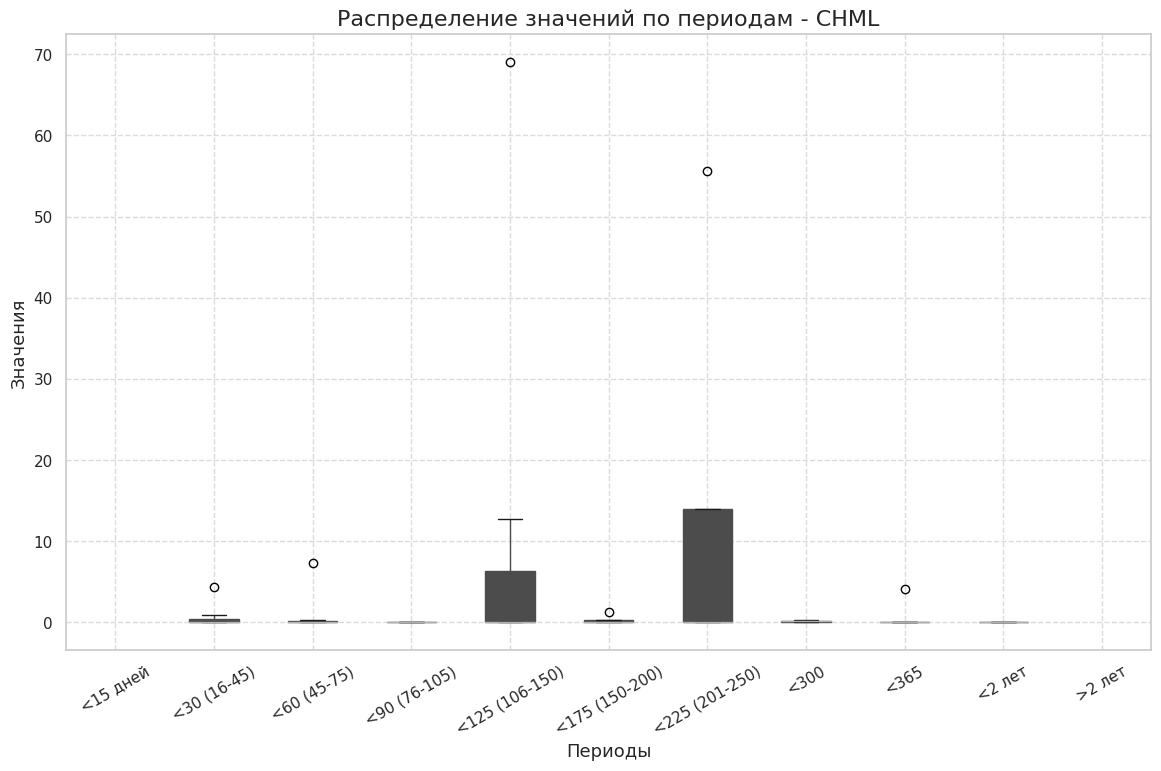

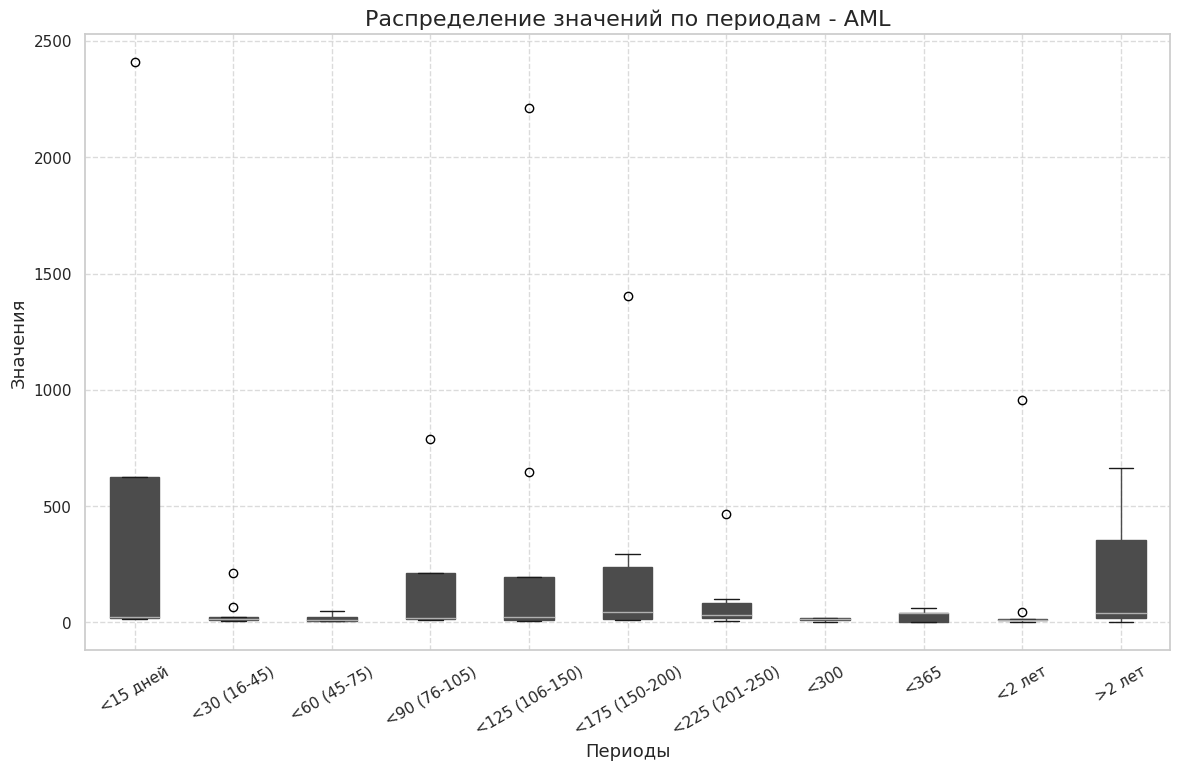

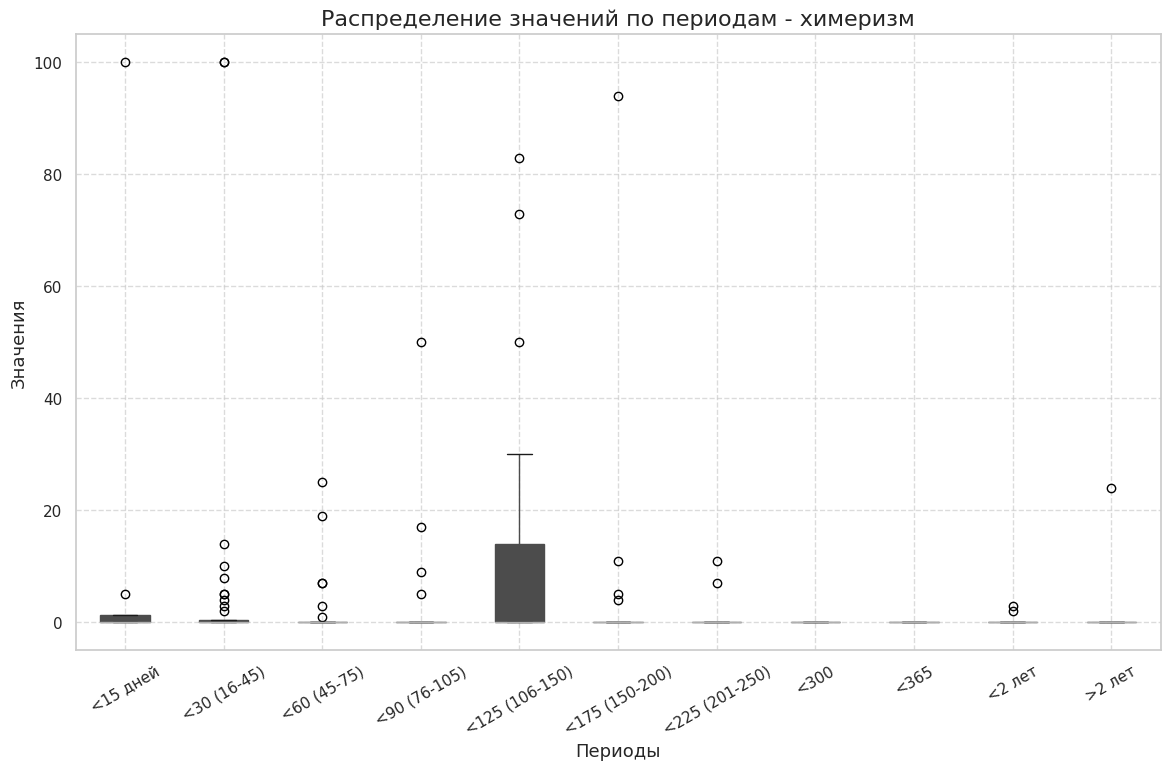

In [8]:
def prepare_df(file_path, start_column_name):
    df = pd.read_csv(file_path)
    df['Номер ТКМ'] = df['Номер ТКМ'].astype('str')
    df.insert(0, 'Реципиент_ТКМ', df['Реципиент'] + '_' + df['Номер ТКМ'])

    start_idx = df.columns.get_loc(start_column_name)
    df_T = df.iloc[:, start_idx:].T

    return df, df_T

file_paths = [
    '/content/drive/MyDrive/МОБ/ОЛЛ_проточка.csv',
    '/content/drive/MyDrive/МОБ/ХМЛ_BCR-ABL1.csv',
    '/content/drive/MyDrive/МОБ/ОМЛ_Wt1.csv'
]
start_column_name = "<15 дней"

dfs = []
for file_path in file_paths:
    df, df_T = prepare_df(file_path, start_column_name)
    dfs.append((df, df_T))

all_df, all_df_T = dfs[0]
chml_df, chml_df_T = dfs[1]
aml_df, aml_df_T = dfs[2]


def plot_boxplot(df, title):
    plt.figure(figsize=(14, 8), dpi=100)
    sns.set(style="whitegrid")

    box = df.boxplot(
        column=['<15 дней', '<30 (16-45)', '<60 (45-75)', '<90 (76-105)', '<125 (106-150)',
                '<175 (150-200)', '<225 (201-250)', '<300', '<365', '<2 лет', '>2 лет'],
        grid=True,
        patch_artist=True
    )

    plt.xticks(fontsize=11, rotation=30)
    plt.yticks(fontsize=11)
    plt.xlabel('Периоды', fontsize=13)
    plt.ylabel('Значения', fontsize=13)
    plt.title(title, fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_boxplot(all_df, 'Распределение значений по периодам - ALL')
plot_boxplot(chml_df, 'Распределение значений по периодам - CHML')
plot_boxplot(aml_df, 'Распределение значений по периодам - AML')
plot_boxplot(chim_df, 'Распределение значений по периодам - химеризм')

# Нормализация данных

Суть нормализации алгоритмом sklearn MinMaxScaler:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler


In [9]:
def normalize_and_format(data, names, time_labels):
    scaler = preprocessing.MinMaxScaler()
    normalized_data = scaler.fit_transform(data)  # Применение нормализации
    df = pd.DataFrame(normalized_data, columns=names)
    df.insert(0, "Time", time_labels)
    df['Average'] = df.mean(numeric_only=True, axis=1)
    df = df.set_index('Time')
    return df

# Входные данные
time_labels = ['<15 дней', '<30 (16-45)', '<60 (45-75)', '<90 (76-105)', '<125 (106-150)',
               '<175 (150-200)', '<225 (201-250)', '<300', '<365', '<2 лет', '>2 лет']

# Создание подвыборок и их транспонирование
all_chim = chim_df.query("Диагноз == 'ALL'").iloc[:, 8:].T
aml_chim = chim_df.query("Диагноз == 'AML'").iloc[:, 8:].T
chml_chim = chim_df.query("Диагноз == 'CML'").iloc[:, 8:].T

# Нормализация данных
scaled_chim_all = normalize_and_format(all_chim, all_df['Реципиент_ТКМ'].tolist(), time_labels)
scaled_all = normalize_and_format(all_df_T, all_df['Реципиент_ТКМ'].tolist(), time_labels)

scaled_chim_aml = normalize_and_format(aml_chim, aml_df['Реципиент_ТКМ'].tolist(), time_labels)
scaled_aml = normalize_and_format(aml_df_T, aml_df['Реципиент_ТКМ'].tolist(), time_labels)

scaled_chim_chml = normalize_and_format(chml_chim, chml_df['Реципиент_ТКМ'].tolist(), time_labels)
scaled_chml = normalize_and_format(chml_df_T, chml_df['Реципиент_ТКМ'].tolist(), time_labels)


Text(0, 0.5, '')

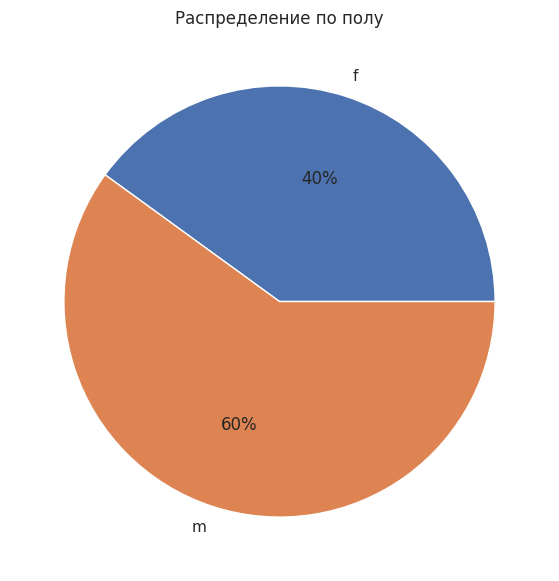

In [10]:
plt.figure(figsize=(12,7), dpi= 100)
df_plot = chim_df.drop_duplicates(subset=['Реципиент']).groupby('Пол').size()

df_plot.plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%.0f%%')
plt.title("Распределение по полу");
plt.ylabel("")

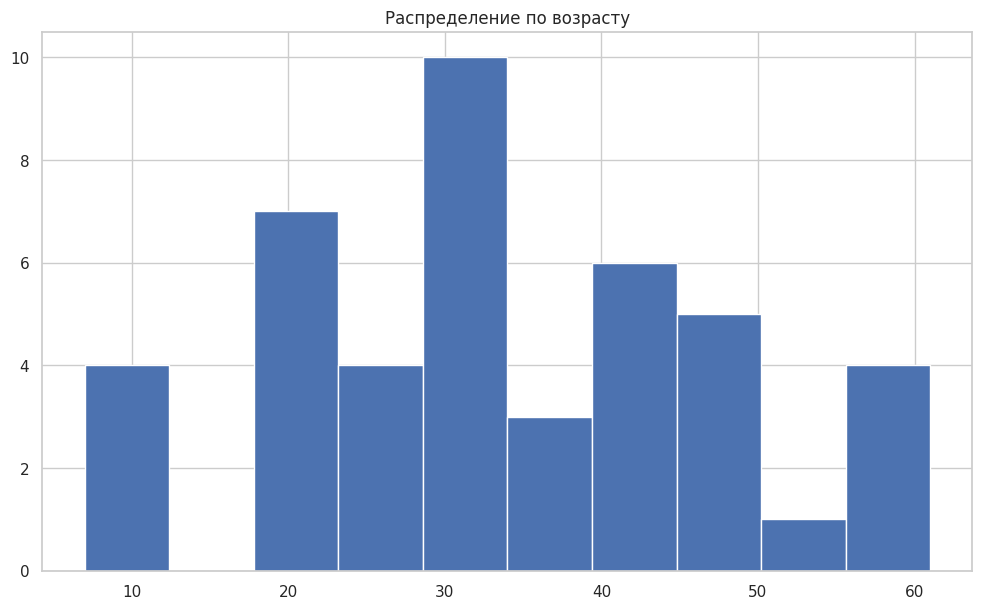

In [11]:
plt.figure(figsize=(12,7), dpi= 100)
chim_df.drop_duplicates(subset=['Реципиент'])['Возраст'].hist()
plt.title("Распределение по возрасту");

Text(0, 0.5, '')

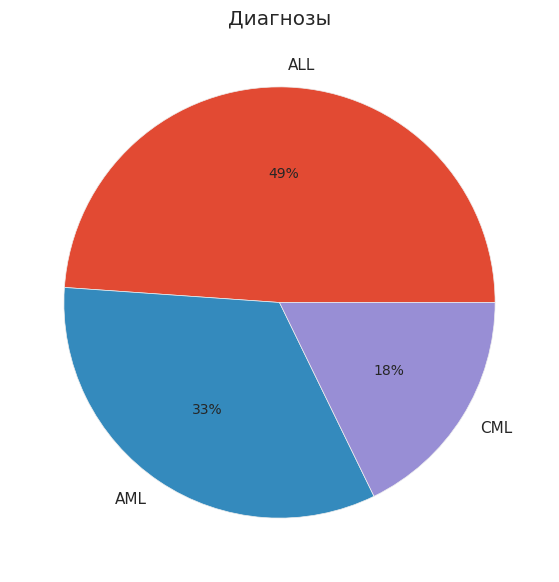

In [12]:
plt.style.use("ggplot")
plt.figure(figsize=(12,7), dpi= 100)
df_plot = chim_df.drop_duplicates(subset=['Реципиент']).groupby('Диагноз').size()

df_plot.plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%.0f%%')
plt.title("Диагнозы");
plt.ylabel("")


Text(0, 0.5, '')

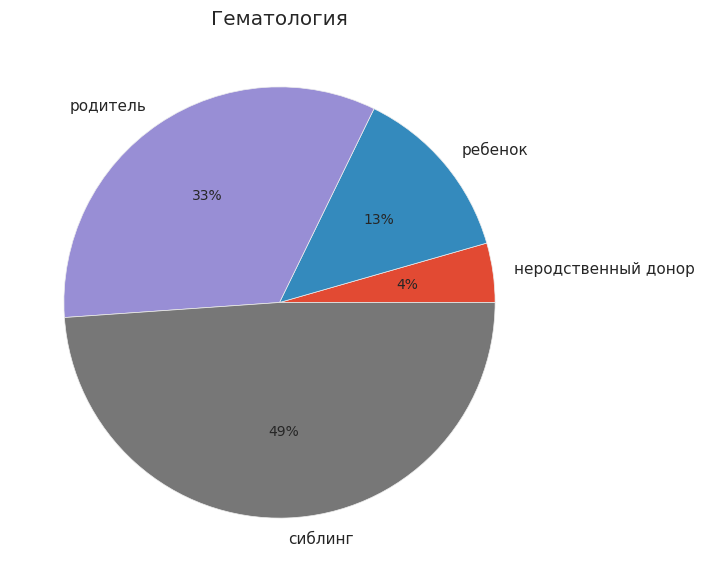

In [13]:
plt.figure(figsize=(12,7), dpi= 100)
df_plot = chim_df.drop_duplicates(subset=['Реципиент']).groupby('Донор').size()

df_plot.plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%.0f%%')
plt.title("Гематология");
plt.ylabel("")


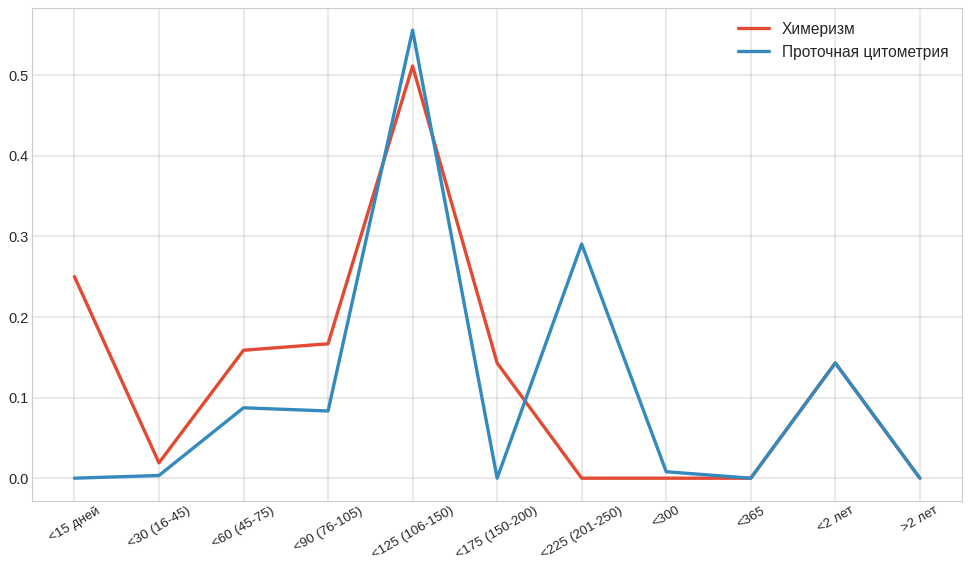

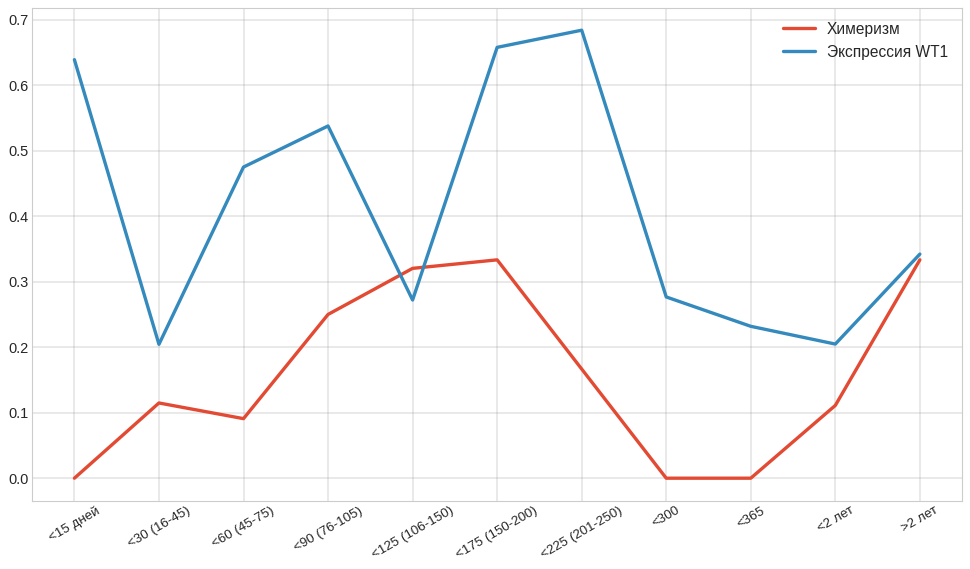

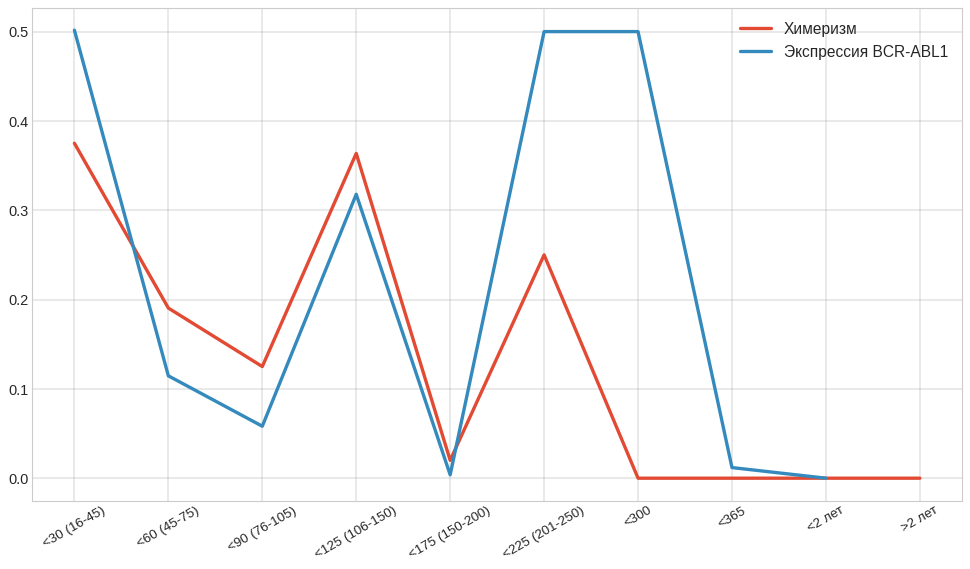

In [19]:
def plot_and_save(data_index, data1, data2, label1, label2, filename):
    plt.figure(figsize=(15, 8), dpi=80)
    plt.xticks(fontsize=12, rotation=30)
    plt.yticks(fontsize=13)
    plt.plot(data_index, data1, label=label1, lw=3)
    plt.plot(data_index, data2, label=label2, lw=3)
    plt.legend(fontsize=14)
    plt.grid(color='gray', linewidth=0.3)
    plt.savefig(f'{filename}.png', format='png')
    plt.show()


plot_params = [
    (scaled_all.index, scaled_chim_all['Average'], scaled_all['Average'],
     "Химеризм", "Проточная цитометрия", "all"),

    (scaled_aml.index, scaled_chim_aml['Average'], scaled_aml['Average'],
     "Химеризм", "Экспрессия WT1", "aml"),

    (scaled_chml.index, scaled_chim_chml['Average'], scaled_chml['Average'],
     "Химеризм", "Экспрессия BCR-ABL1", "cml")
]

# Построение графиков
for params in plot_params:
    plot_and_save(*params)

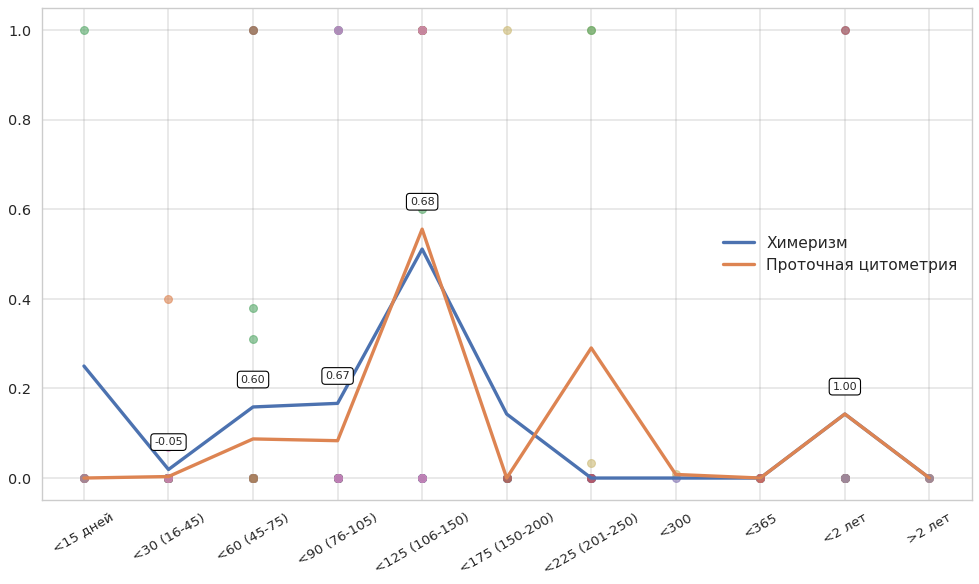

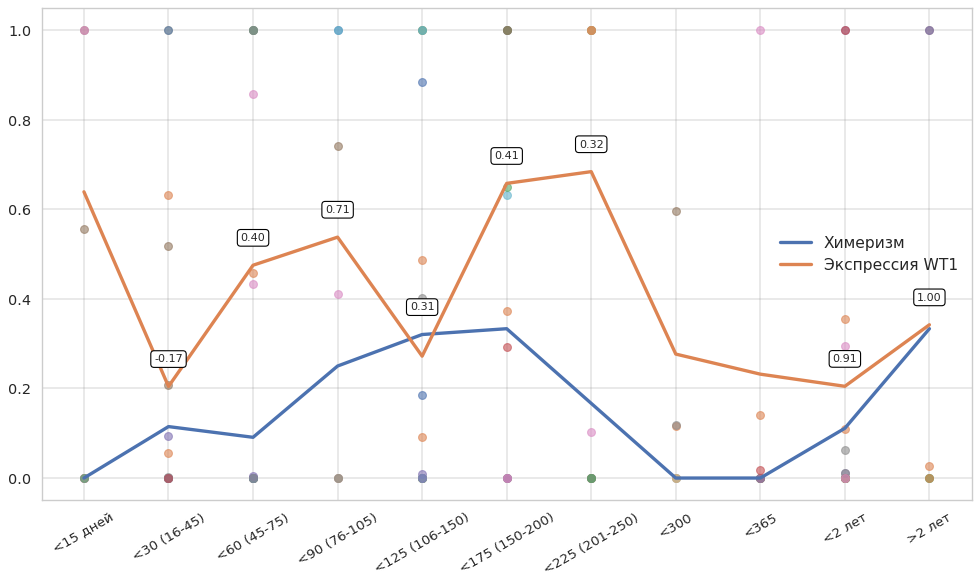

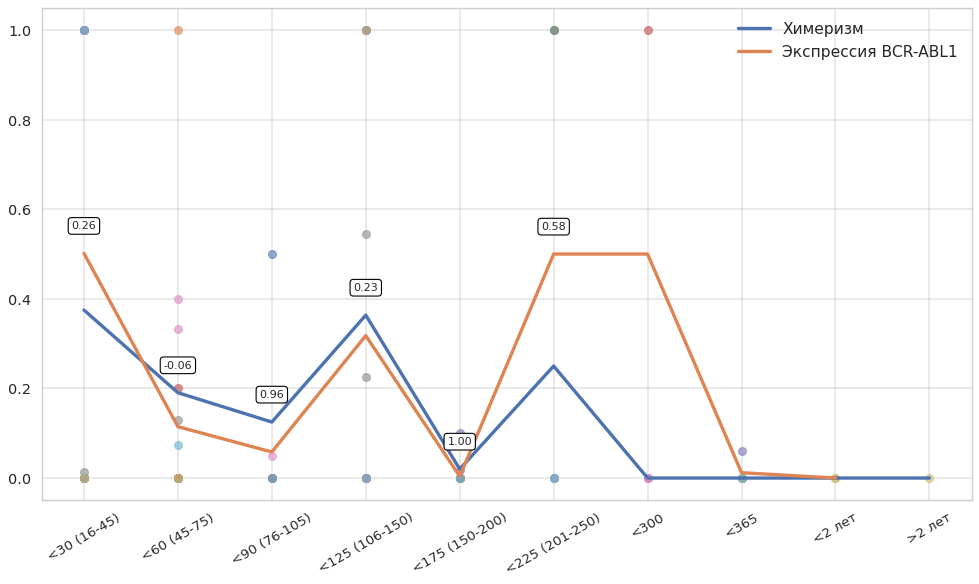

In [29]:
def plot_and_save(data_index, data1, data2, data_points1, data_points2, label1, label2, filename, title=None):
    plt.figure(figsize=(15, 8), dpi=80)
    plt.xticks(fontsize=12, rotation=30)
    plt.yticks(fontsize=13)

    # Построение линии среднего значения
    plt.plot(data_index, data1, label=label1, lw=3)
    plt.plot(data_index, data2, label=label2, lw=3)

    # Визуализация данных пациентов точками
    for column in data_points1.columns:
        plt.scatter(data_index, data_points1[column], alpha=0.6, s=50)  # Точки для химеризма
    for column in data_points2.columns:
        plt.scatter(data_index, data_points2[column], alpha=0.6, s=50)  # Точки для другого метода

    # Вычисление и аннотация корреляции по каждой временной точке
    correlations = []
    for time_point in data_index:
        if time_point in data_points1.index and time_point in data_points2.index:
            corr_value = data_points1.loc[time_point].corr(data_points2.loc[time_point])
            correlations.append(corr_value)
        else:
            correlations.append(None)

    # Добавление текста с корреляцией на график рядом с каждой временной точкой (если корреляция не NaN)
    for i, (time_point, corr_value) in enumerate(zip(data_index, correlations)):
        if corr_value is not None and not pd.isna(corr_value):  # Проверка на NaN
            plt.text(i, max(data1[i], data2[i]) + 0.05, f'{corr_value:.2f}',
                     fontsize=10, verticalalignment='bottom', horizontalalignment='center',
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    plt.legend(fontsize=14)
    plt.grid(color='gray', linewidth=0.3)

    if title:
        plt.title(title, fontsize=20)

    plt.savefig(f'{filename}.png', format='png')
    plt.show()

# Параметры для графиков
plot_params = [
    (scaled_all.index,
     scaled_chim_all['Average'], scaled_all['Average'],  # Средние значения
     scaled_chim_all.drop(columns=['Average']), scaled_all.drop(columns=['Average']),  # Данные по пациентам
     "Химеризм", "Проточная цитометрия", "all"),

    (scaled_aml.index,
     scaled_chim_aml['Average'], scaled_aml['Average'],
     scaled_chim_aml.drop(columns=['Average']), scaled_aml.drop(columns=['Average']),
     "Химеризм", "Экспрессия WT1", "aml"),

    (scaled_chml.index,
     scaled_chim_chml['Average'], scaled_chml['Average'],
     scaled_chim_chml.drop(columns=['Average']), scaled_chml.drop(columns=['Average']),
     "Химеризм", "Экспрессия BCR-ABL1", "cml")
]

# Построение графиков
for params in plot_params:
    plot_and_save(*params)

In [24]:
df_wt1 = pd.read_csv('/content/drive/MyDrive/МОБ/База МОБ_1.csv')
df_wt1 = df_wt1.query("Метод == 'ПЦР- Inogen, выделение Qiagen'").iloc[:-4]
df_wt1 = df_wt1[['Результат', 'исход']]
df_wt1['исход'] = np.where(df_wt1['исход'] == 'Рецидив', 1, 0)
df_wt1['Результат'] = df_wt1['Результат'].astype('float')
df_wt1

,Результат,исход
0,10.16,0
1,2213.00,1
2,1404.00,1
3,11.50,0
4,5.00,0
...,...,...
73,12.70,0
74,48.00,0
75,14.00,0
76,27.70,0


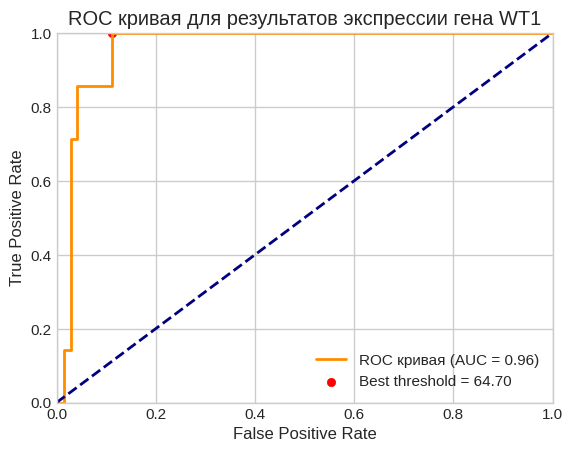

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df_wt1['исход'], df_wt1['Результат'])
roc_auc = auc(fpr, tpr)

j_scores = tpr - fpr

best_threshold_index = j_scores.argmax()
best_threshold = thresholds[best_threshold_index]

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], marker='o', color='red', label='Best threshold = %0.2f' % best_threshold)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для результатов экспрессии гена WT1')
plt.legend(loc="lower right")
plt.show()